# Saving the Rainforest with Random Forests
### Claire Longo
### July 2017
Kaggle Compitition code
Planet: Understanding the Amazon from Space

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space

The goal of this competition is to label satellite images of the Amazon rainforest. The goal of this algorithm is to identify and understand the where, how and why of deforestation. This is a computer vision task requiring multilabel classification with large class unbalance. This approach uses .jpeg image data to train the model, and meaningful features are engineering from the raw image files.

## Exploratory Data Analysis

In [98]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from skimage.io import imread, imshow
from skimage import transform, img_as_float
import glob
import math
from importlib import reload

In [99]:
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'src')
if not path in sys.path:
    sys.path.append(path)
#del cwd, path
import KaggleAmazonMainClaire as kam #library of functions used in this notebook

In [100]:
reload(kam) #reloads library. Use if it has been updated

<module 'KaggleAmazonMainClaire' from 'C:\\Work\\Kaggle\\Planet\\kaggle_UnderstandingAmazonFromSpace\\develop\\..\\src\\KaggleAmazonMainClaire.py'>

In [101]:
#Load from pickle unless something has changed
#the data takes a while to read in and format, so it is saved as a pickle file once it is formatted
X = pd.read_pickle('X_train.pkl')
y = pd.read_pickle('y_train.pkl')
y[y > 1] = 1 #fix labels accidently labels twice. This was just a mistake in tagging. oops. 
X_sample, labels, names_train, tagged_df = kam.load_sample_training_data() #load sample data for plotting

cwd C:\Work\Kaggle\Planet\kaggle_UnderstandingAmazonFromSpace\develop
Loading jpg image dataset


These example images are from the training dataset. Images are tagged with more than one label.

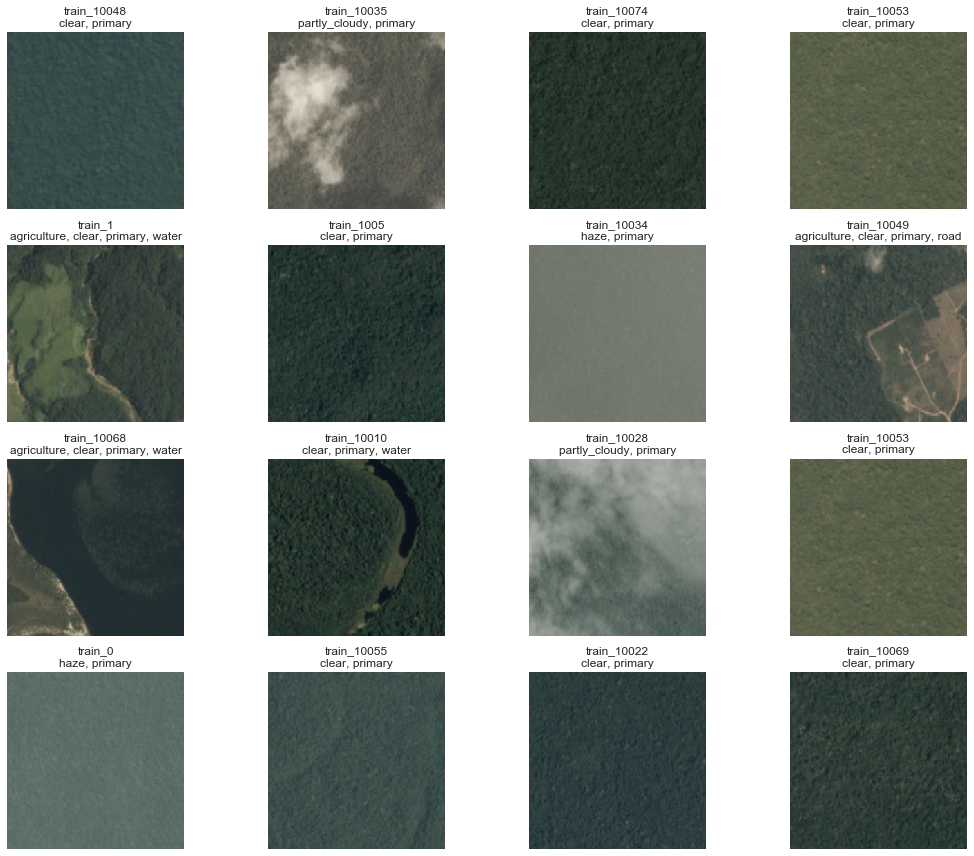

In [102]:
%matplotlib inline
kam.plot_samples(X_sample, names_train, tagged_df, nrow=4, ncol=4)

The bar plot shows the sample size for each tag in the training dataset. Notice the large class unbalance. The tags that do not occure very frequently will be difficult to train a model to identify, because there are not many cases in the training data. 

There are 17 unique tags in this data


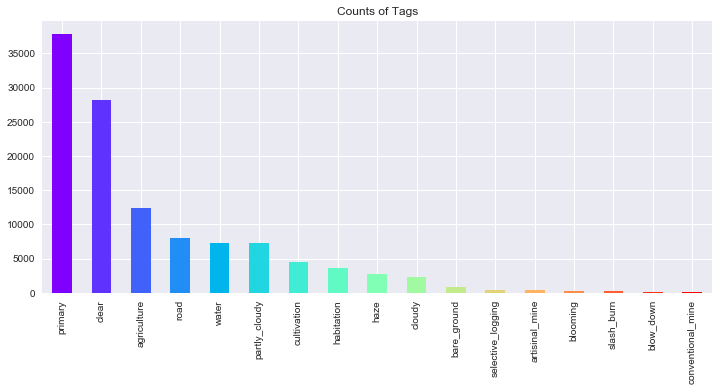

In [103]:
#Barplot of tag counts
def plot_sample_size(tagged_df):
    plt.rcParams['figure.figsize'] = (12, 5)
    print('There are {} unique tags in this data'.format(len(tagged_df.columns)))
    colors = cm.rainbow(np.linspace(0, 1, len(tagged_df.columns)))
    tagged_df.sum().sort_values(ascending=False).plot(title="Counts of Tags", color=colors, kind='bar')
    plt.show()
kam.plot_sample_size(tagged_df)

## Feature Engineering
The images contain numeric pixel values on the red, green, and blue scale. The statistical distributions of the red, green, and blue, pixels differ for different types of tags, indicating that this may be a useful feature for classification. The patterns in these pixels will likely have useful trends for classifying the objects in the images and the image types. The  image below shows the red, green, and blue image layers.

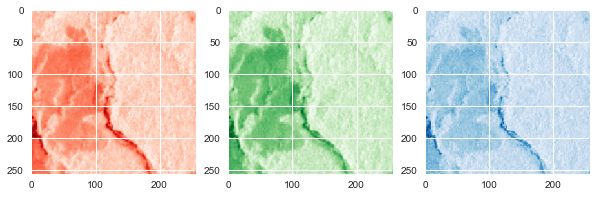

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes[0].imshow(X_sample[1,:,:,0], cmap='Reds')
axes[1].imshow(X_sample[1,:,:,1], cmap='Greens')
axes[2].imshow(X_sample[1,:,:,2], cmap='Blues')

The tags ae based on patterns in the images, but the location of these patterns does not matter. For example a road in the bottom corner or top corner of an image is still a road, and we are only interested in tagging it as such. Therefore, the raw pixel data is not an optimal feature because it defines patterns in specific locations. Thus, we engineer features from the raw pixel data that attempt to represent generalized patterns in the images.

Many of the red, green, and blue distributions are bimodal, which could offer interesting insight into the classification, so  a feature is created  to capture bimodal patterns in the r g b pixel distributions. The binned mode differences is simply the difference between the two min bounds of the two largest count bins, or the two modes. If this value is large, then the two largest modes are a large distance from each other, indicating the distribution is bimodal.

The mean of the red distribution is 0.22
After splitting on the mean, the two modes are found at [ 0.16] and [ 0.3]


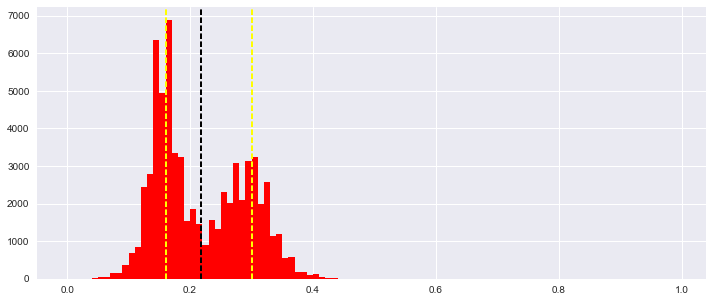

The mean of the green distribution is 0.22
After splitting on the mean, the two modes are found at [ 0.2] and [ 0.27]


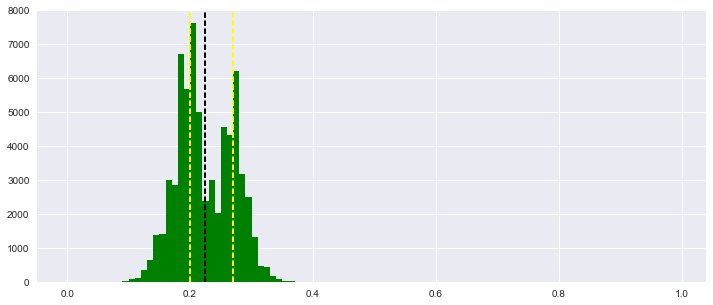

The mean of the blue distribution is 0.2
After splitting on the mean, the two modes are found at [ 0.18] and [ 0.23]


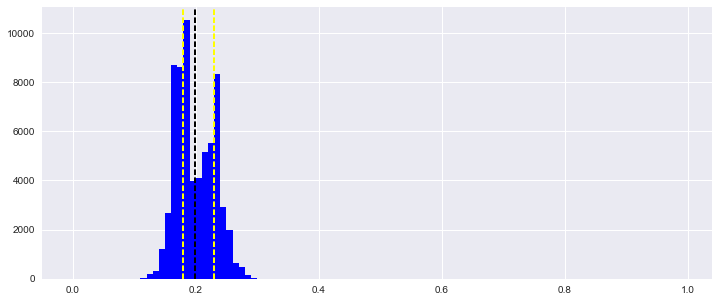

(0.14000000000000001, 0.070000000000000007, 0.050000000000000003)

In [105]:
#Binned mode differences


def binned_mode_features_with_diagnostics(img, steps):
    ## red ##
    #split on mean
    m=img[:,:,0].flatten().mean()
    left = img[:,:,0].flatten()[img[:,:,0].flatten()<m]
    right = img[:,:,0].flatten()[img[:,:,0].flatten()>=m]
    #find mode in left and right
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    #calc bimodal metric
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_r=abs(mo1-mo2)
    print("The mean of the red distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,0].flatten(), color='red', bins=steps)
    plt.axvline(img[:,:,0].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    ## green ##
    m=img[:,:,1].flatten().mean()
    left = img[:,:,1].flatten()[img[:,:,1].flatten()<m]
    right = img[:,:,1].flatten()[img[:,:,1].flatten()>=m]
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_g=abs(mo1-mo2)
    print("The mean of the green distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,1].flatten(), color='green', bins=steps)
    plt.axvline(img[:,:,1].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    ## blue ##
    m=img[:,:,2].flatten().mean()
    left = img[:,:,2].flatten()[img[:,:,2].flatten()<m]
    right = img[:,:,2].flatten()[img[:,:,2].flatten()>=m]
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_b=abs(mo1-mo2)
    print("The mean of the blue distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,2].flatten(), color='blue', bins=steps)
    plt.axvline(img[:,:,2].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    return mods_diff_r[0].round(2), mods_diff_g[0].round(2), mods_diff_b[0].round(2)

img=X_sample[2]
steps=np.arange(start=0,stop=1, step=.01)
kam.binned_mode_features_with_diagnostics(img, steps)

Features are also created from the images using sobel and canny transforms in the skimage library. The sobel and canny transformations from skimage perform edge detection of the images. An example of the Sobel transformation is plotted below. 

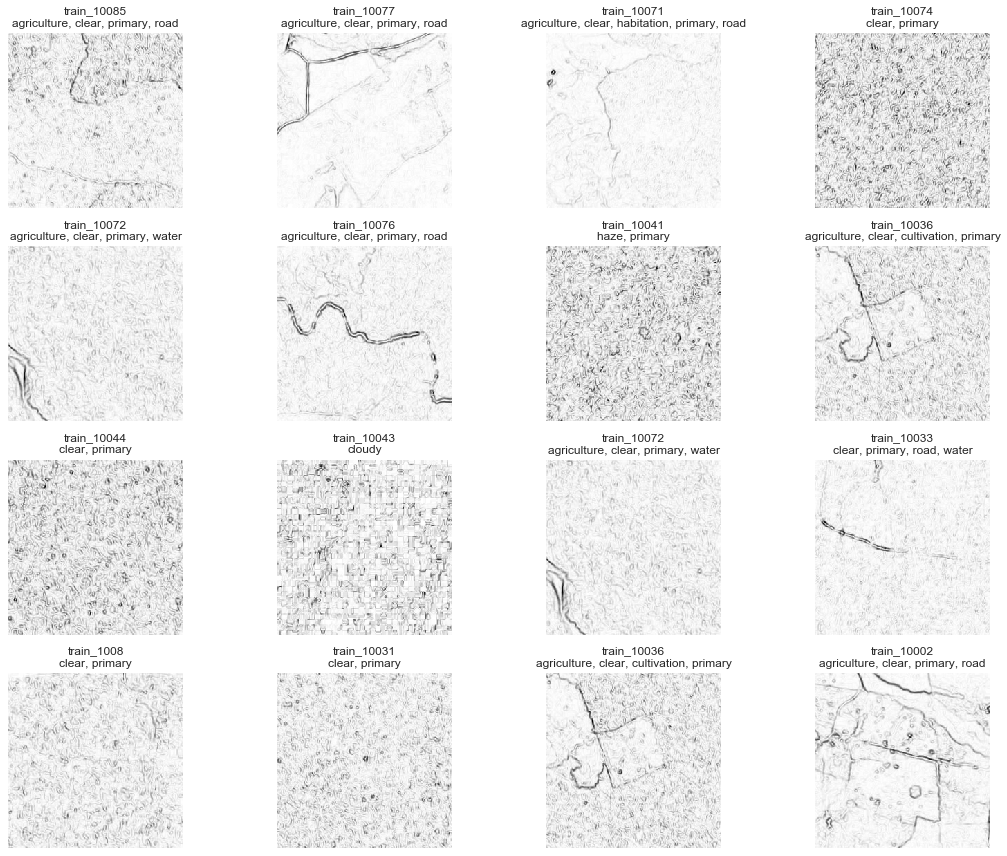

In [106]:
#This code is not mine#
from skimage.color import rgb2gray
from skimage import transform, img_as_float, filters
X_train_g = rgb2gray(X_sample)

X_train_sobel = []
for i in range(X_train_g.shape[0]):
    X_train_sobel.append(filters.sobel(X_train_g[i]))
X_train_sobel = np.asarray(X_train_sobel)
kam.plot_samples(X_train_sobel, names_train, tagged_df, 4,4)

In [107]:
#create table of each feature histograms for each label
X.set_index(y.index, inplace=True)
print(X.columns) #possible features to plot

Index(['b_bimodal', 'b_kurtosis', 'b_max', 'b_mean', 'b_min', 'b_skew',
       'b_std', 'g_bimodal', 'g_kurtosis', 'g_max', 'g_mean', 'g_min',
       'g_skew', 'g_std', 'r_bimodal', 'r_kurtosis', 'r_max', 'r_mean',
       'r_min', 'r_skew', 'r_std', 'sobel_colmean_std', 'sobel_kurtosis',
       'sobel_max', 'sobel_mean', 'sobel_min', 'sobel_rowmean_std',
       'sobel_skew', 'sobel_std'],
      dtype='object')


The list above shows all the features that have been created. To check if these features actually describe patterns in the classed, I plotted histograms of the features by each tag. If the patterns in the histograms differ, then the feature may be informative in defining the classes. The two features plotted below are for the blue bimodal feature, and the sobel column mean standard deviation. 


Blue bimodal feauture


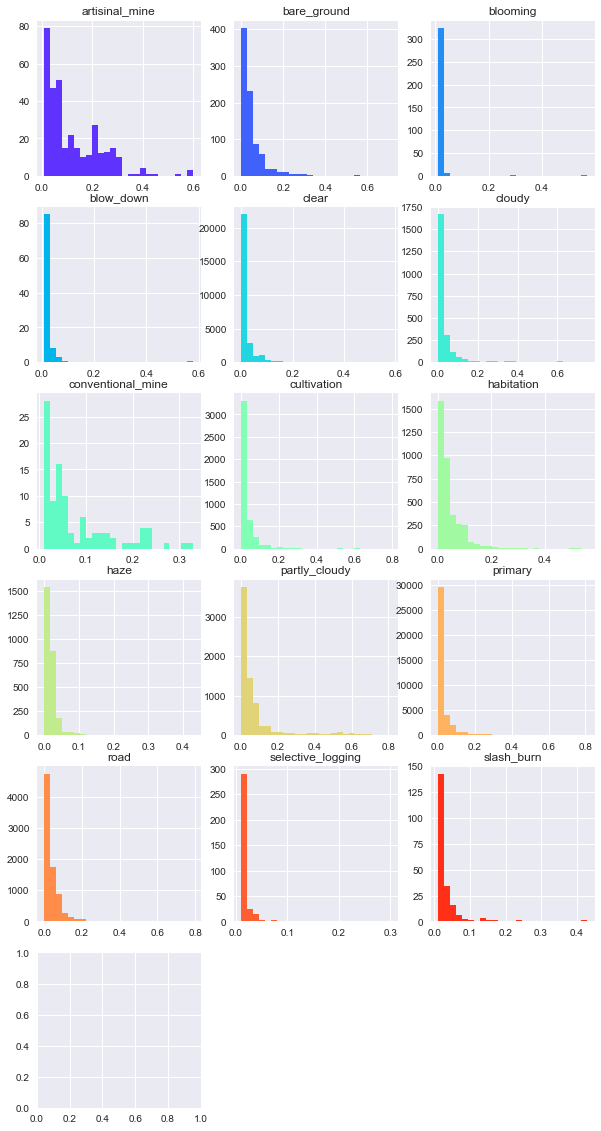

sobel column mean standard deviation


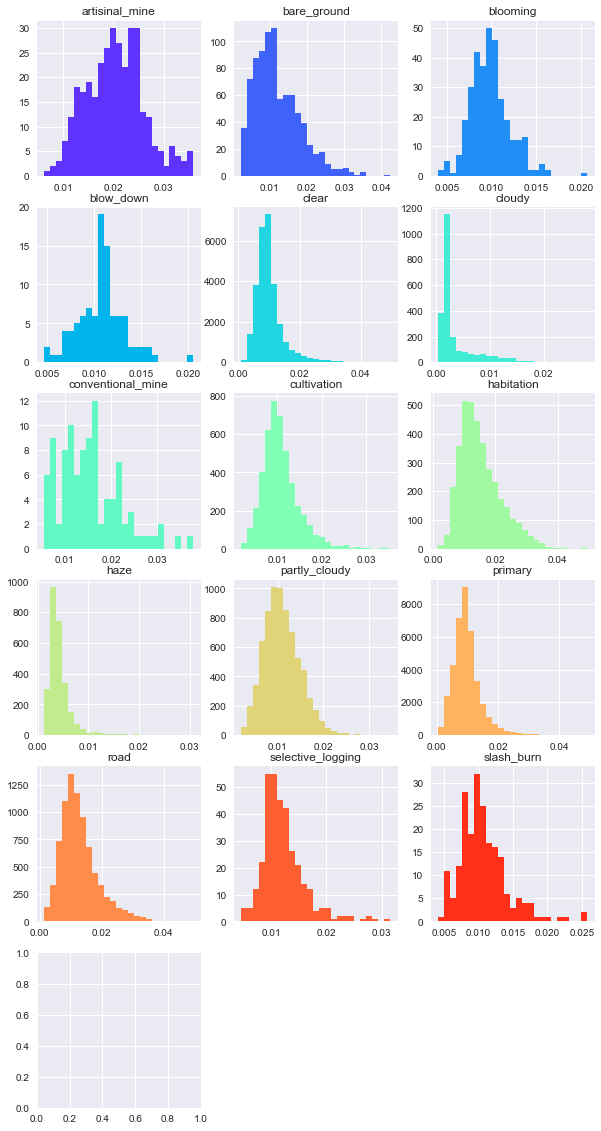

In [108]:
plt.rcParams['figure.figsize'] = (10, 20)
#function to plot distributions of a features by class label
def plot_a_feature_by_labels(feature):
    colors = cm.rainbow(np.linspace(0, 1, len(y.columns))) #pick colors for plots by labels
    for i in np.arange(0, len(y.columns)-1):
        col=y.columns[i]
        ind_list = y[y[col]==1].index.tolist()
        X.ix[ind_list][feature].hist(bins=25, color=colors[i])
        plt.title(col)
        plt.grid(True)
        plt.subplot(6,3,i+1) 

print("Blue bimodal feauture")
plot_a_feature_by_labels('b_bimodal')   
plt.show()
print("sobel column mean standard deviation")
plot_a_feature_by_labels('sobel_colmean_std')
plt.show()

## Random Forest Modeling
Random Forest with balanced sampling to account for unbalanced classes. 

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.40, random_state=14113) 

In [110]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, 
                            max_features = 'sqrt',
                            bootstrap = True, 
                            oob_score = True,
                            n_jobs = -1,
                            random_state = 14113,
                            class_weight = 'balanced_subsample')

In [111]:
rf.fit(X_train, y_train)
print('The oob error for this random forest is {}'.format(rf.oob_score_.round(2)))

The oob error for this random forest is 0.95


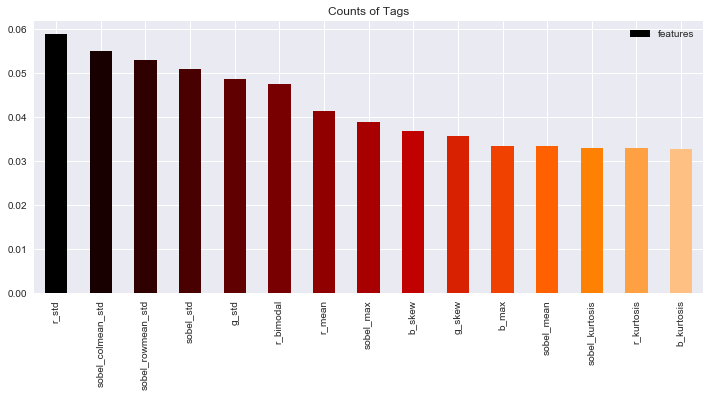

In [112]:
#features ranking of features. 
Feature_importance = pd.DataFrame(rf.feature_importances_, X_train.columns)
def plot_feature_importance(Feature_importance, n):
    '''
    plot top n features
    '''
    plt.rcParams['figure.figsize'] = (12, 5)
    Feature_importance = pd.DataFrame(rf.feature_importances_, X_train.columns)
    Feature_importance.columns = ['features']
    Feature_importance = Feature_importance.sort_values(by='features', axis=0, ascending=False)
    colors = cm.gist_heat(np.linspace(0, 1, len(tagged_df.columns)))
    Feature_importance.head(n).plot(title="Counts of Tags", color=colors, kind='bar')
    plt.show()

plot_feature_importance(Feature_importance, 15)

## F2-score and other metrics
Compute the F2-score because this is the metric used to score the competition. The F2 score is calculated from precision and accuracy, and weights the recall higher than the precision. 
(Note the warning is for the classes with very small sample size.)

ROC curves visualize performance of a classifier via precision and recall tradeoff. Visualization of how predicted probabilities compare to the truth. The ROC curve and histogram look at the performance of two classes, a large class and a small (agriculture and bare ground). The model performs well for tags with large sample size, but poor recall performance come from the small classes. 

In [113]:
from sklearn.metrics import fbeta_score
np.asarray(y_validation)
predictions = rf.predict(X_validation)
fbeta_score(np.asarray(y_validation), predictions, beta=2, average='samples')

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.8370163549164279

In [114]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_validation, predictions)
Metrics = pd.DataFrame([precision, recall, support], index=['precision', 'recall', 'support'])
Metrics.columns = y_validation.columns
Metrics

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
precision,0.794624,0.970588,1.000000,0.0,0.0,0.937878,0.850192,0.0,0.676364,0.805369,0.780987,0.926775,0.970510,0.754006,0.0,0.0,0.795229
recall,0.740926,0.235714,0.005634,0.0,0.0,0.965777,0.761468,0.0,0.103448,0.392927,0.580501,0.748753,0.992084,0.576240,0.0,0.0,0.272387
support,4987.000000,140.000000,355.000000,133.0,46.0,11396.000000,872.000000,44.0,1798.000000,1527.000000,1118.000000,2806.000000,15160.000000,3266.000000,140.0,86.0,2937.000000


In [115]:
probs = rf.predict_proba(X_validation)

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


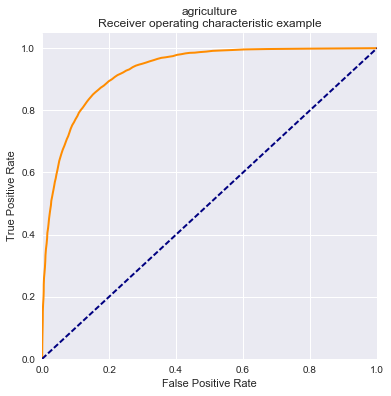

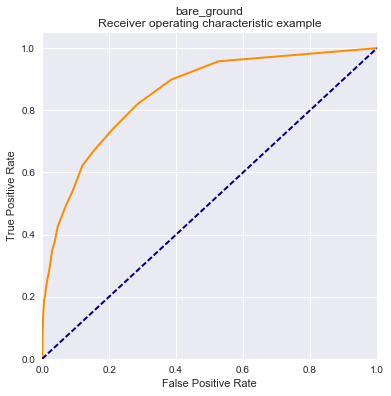

In [116]:
from sklearn import metrics

def plot_ROC(tag):
    '''
    plot ROC curve for a specific tag
    '''
    plt.rcParams['figure.figsize'] = (6,6)
    n = np.where(y_validation.columns==tag)[0][0]
    fpr, tpr, threshs = metrics.roc_curve(y_validation[tag], probs[n][:,1],
                                          pos_label=None, sample_weight=None, drop_intermediate=False)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(tag+'\nReceiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
plot_ROC('agriculture')
plot_ROC('bare_ground')

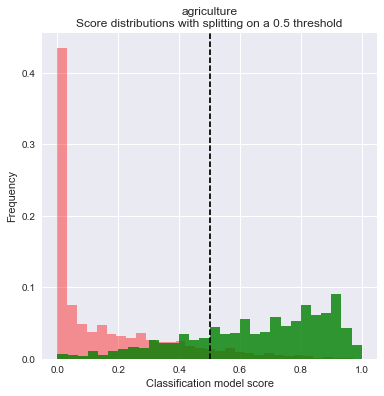

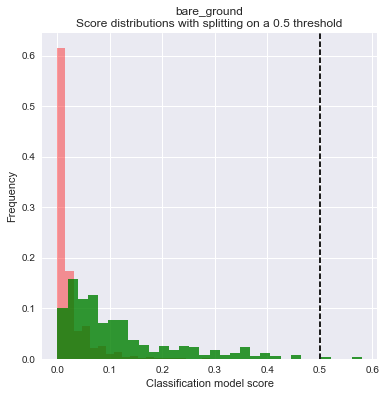

In [117]:
def plot_decision_hist(tag):
    '''
    plots decision histograms with thresholds
    '''
    plt.rcParams['figure.figsize'] = (6,6)
    #Less than .5 is 0. greater is 1
    n = np.where(y_validation.columns==tag)[0][0]
    probs_df = pd.DataFrame(probs[n][:,1]).set_index(y_validation[tag])
    class0 =  np.array(probs_df.ix[0][0]) #0 does not have true tag
    class1 =  np.array(probs_df.ix[1][0]) #1 does have true tag

    S = class0
    # Histogram:
    # Bin it
    n, bin_edges = np.histogram(S, 30)
    # Normalize it, so that every bins value gives the probability of that bin
    bin_probability = n/float(n.sum())
    # Get the mid points of every bin
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    # Compute the bin-width
    bin_width = bin_edges[1]-bin_edges[0]
    # Plot the histogram as a bar plot
    plt.bar(bin_middles, bin_probability, width=bin_width, color='red', alpha=.4)

    S = class1
    n, bin_edges = np.histogram(S, 30)
    bin_probability = n/float(n.sum())
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    bin_width = bin_edges[1]-bin_edges[0]
    plt.bar(bin_middles, bin_probability, width=bin_width, color='green', alpha=.8)

    plt.axvline(x=0.5, color='k', linestyle='--')
    plt.title(tag+'\nScore distributions with splitting on a 0.5 threshold')
    plt.xlabel('Classification model score')
    plt.ylabel('Frequency')
    plt.show()
    
plot_decision_hist('agriculture')
plot_decision_hist('bare_ground')    